In [1]:
#-*- coding:utf-8 -*-

import os
import sys
import time
import random
import math
import pickle
import unicodedata

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as st
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime, timedelta
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from sklearn.preprocessing import StandardScaler

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import robject

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

rTE = importr('RTransferEntropy')
rTE.set_quiet(True)

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f0e08177600> [RTYPES.NILSXP]

In [3]:
from utils_p import *

In [4]:
# setup seed
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

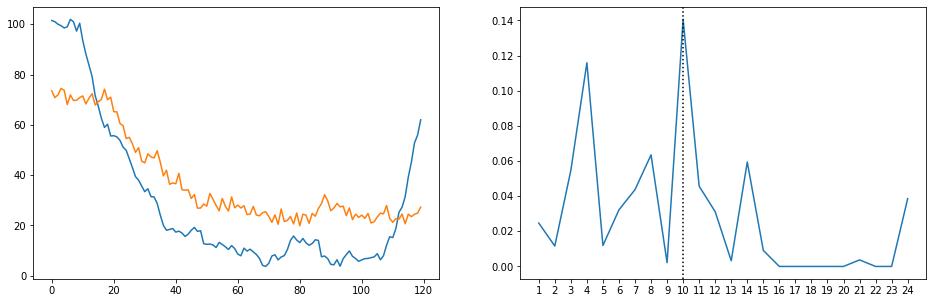

In [5]:
n = 120

while True:
    x = [100] * n + np.random.normal(0, 1, n)*2
    # for i in range(10): 
    #     x[i] = x[i] + np.random.normal(0, 10)

    for i in np.arange(10,n):
        if i < 100:
            x[i] = 0.95 * x[i-1] + np.random.normal(0,1)*2
        else: 
            x[i] = 1.10 * x[i-1] + np.random.normal(0,1)*2
    x = pd.Series(x)

    if np.min(x) > 0:
        break

lag = 10
k = 0

while True:
    random.seed(k)
    np.random.seed(k)
    
    y = [70] * n + np.random.normal(0, 1, n)*2
    for i in range(lag, n):
        y[i] = 0.5 * x[i-lag] + 20 + np.random.normal(0,1)*2
    y = pd.Series(y)

    out = []
    for lag_test in np.arange(1,25,1):
        x_copy = x.to_numpy().copy()
        y_copy = y.to_numpy().copy()

        ETE_value = rTE.calc_ete(x = x_copy[1:(len(x_copy)-lag_test)+1], y = y_copy[(lag_test):len(y_copy)],lx=1,ly=1)
        out.append([lag_test, np.asarray(ETE_value).item()])
        
    #check TE
    if lag == (np.argmax(np.array(out)[:,1])+1):
        fig, ax = plt.subplots(1, 2, figsize=(16,5))
        ax[0].plot(x)
        ax[0].plot(y)

        ax[1].plot(np.array(out)[:,0], np.array(out)[:,1])
        ax[1].set_xticks(np.arange(1,25))
        ax[1].axvline(lag, color='k', ls=':')

        plt.show()
        break
    
    k += 1

In [6]:
x_pre = [100] * 60 + np.random.normal(0, 1, 60)*2
x = pd.Series(np.append(x_pre, x.to_numpy()))

y_pre = [70] * 60 + np.random.normal(0, 1, 60)*2
y = pd.Series(np.append(y_pre, y.to_numpy()))

In [7]:
n_boot_set = [10, 100, 1000]
decompose_set = [True, False]
period_set = [10, 20, 30, 40, 120]

In [8]:
results = []
for n_boot in n_boot_set:
    for decompose in decompose_set:
        
        TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x[-120:], y[-120:], lag=lag, n_boot=n_boot, decompose=decompose, curve=True, plot=False)
        results.append(['1_raw', 120, decompose, n_boot, get_mae(TE_boot_count, lag), *curve[2]])       
        
        for period in period_set:
            x_scaling = scaling(x, period=period)[-120:]
            x_centering = centering(x, period=period)[-120:]
            x_norm = normalization(x, scale=True, period=period)[-120:]      
            
            y_scaling = scaling(y, period=period)[-120:]
            y_centering = centering(y, period=period)[-120:]
            y_norm = normalization(y, scale=True, period=period)[-120:]               
            
            TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_scaling, y_scaling, lag=lag, n_boot=n_boot, decompose=decompose, curve=True, plot=False)
            results.append(['2_min-max', period, decompose, n_boot, get_mae(TE_boot_count, lag), *curve[2]])       

            TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_centering, y_centering, lag=lag, n_boot=n_boot, decompose=decompose, curve=True, plot=False)
            results.append(['3_z-score', period, decompose, n_boot, get_mae(TE_boot_count, lag), *curve[2]])       

            TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_norm, y_norm, lag=lag, n_boot=n_boot, decompose=decompose, curve=True, plot=False)
            results.append(['4_nonlinear', period, decompose, n_boot, get_mae(TE_boot_count, lag), *curve[2]])       

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/home/yongkyung/anaconda3/envs/traffic/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
results_df = pd.DataFrame(results, columns=['setting', 'window', 'decompose', 'n_boot', 'mae', 'mean', 'std'])

In [10]:
results_df.to_csv('results.csv')

In [11]:
results_df.shape

(96, 7)

In [12]:
results_df_mae = results_df[['setting', 'window', 'decompose', 'n_boot', 'mae']]
results_df_mae['target'] = '4_mae'
results_df_mae = results_df_mae.rename({'mae': 'value'}, axis=1)

results_df_mean = results_df[['setting', 'window', 'decompose', 'n_boot', 'mean']]
results_df_mean['target'] = '2_mean'
results_df_mean = results_df_mean.rename({'mean': 'value'}, axis=1)

results_df_std = results_df[['setting', 'window', 'decompose', 'n_boot', 'std']]
results_df_std['target'] = '3_std'
results_df_std = results_df_std.rename({'std': 'value'}, axis=1)

<ipython-input-12-2d33afd41c86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_mae['target'] = '4_mae'
<ipython-input-12-2d33afd41c86>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_mean['target'] = '2_mean'
<ipython-input-12-2d33afd41c86>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [13]:
results_df2 = pd.concat([results_df_mae, results_df_mean, results_df_std], axis=0)
results_df2 = pd.pivot_table(results_df2, 'value', ['n_boot', 'decompose', 'setting', 'target'], 'window')

In [14]:
results_df2.to_csv('results2.csv')

In [15]:
results_df2

window                                     10         20         30   \
n_boot decompose setting     target                                    
10     False     1_raw       2_mean        NaN        NaN        NaN   
                             3_std         NaN        NaN        NaN   
                             4_mae         NaN        NaN        NaN   
                 2_min-max   2_mean  12.500000  12.400000  14.800000   
                             3_std    8.077747   6.359245   6.289674   
...                                        ...        ...        ...   
1000   True      3_z-score   3_std    2.873735   3.581532   3.900431   
                             4_mae    1.577000   2.263000   2.549000   
                 4_nonlinear 2_mean  10.781000  10.297000  10.780000   
                             3_std    2.980443   1.345656   1.487817   
                             4_mae    1.527000   0.937000   1.252000   

window                                     40         120  
n_boot decompose setting     target                        
10     False     1_raw       2_mean        NaN  12.400000  
                             3_std         NaN   6.945502  
                             4_mae         NaN   6.000000  
                 2_min-max   2_mean  13.400000  15.900000  
                             3_std    6.019967   4.968903  
...                                        ...        ...  
1000   True      3_z-score   3_std    4.194440   5.902748  
                             4_mae    2.750000   7.961000  
                 4_nonlinear 2_mean  10.993000  13.379000  
                             3_std    2.042291   6.718137  
                             4_mae    1.717000   6.043000  

[72 rows x 5 columns]